In [1]:
%matplotlib inline
import twixtools
import numpy as np
import matplotlib.pyplot as plt
import os

example_dir = '../example_data'

def ifftnd(sig, axes=[-1]):
    out = sig.copy()
    for axis in axes:
        out = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(out, axes=[axis]), axis=axis), axes=[axis])
    return out


def fftnd(sig, axes=[-1]):
    out = sig.copy()
    for axis in axes:
        out = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(data, axes=[axis]), axis=axis), axes=[axis])
    return out

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.
['Rep', 'Lin', 'Cha', 'Col']


(-0.5, 159.5, -0.5, 159.5)

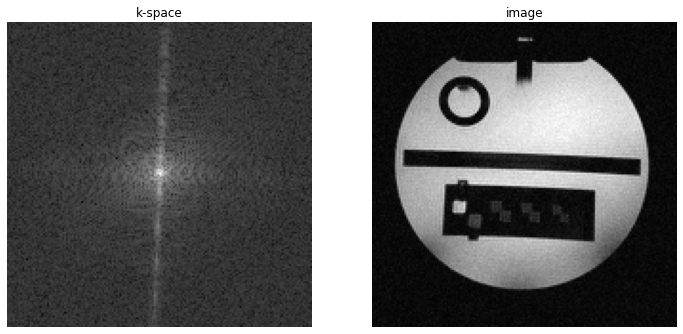

In [2]:
twix_singlechan = twixtools.read_twix(os.path.join(example_dir, 'gre.dat'))
singlechan = twixtools.map_twix(twix_singlechan)
im_data = singlechan[-1]['image']
print(im_data.non_singleton_dims)
im_data.flags['remove_os'] = True
im_data.flags['average']['Rep'] = True
data = im_data[:].squeeze()

plt.figure(figsize=[12,8])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[:,0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

image = ifftnd(data, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(abs(image), cmap='gray', origin='lower')
plt.axis('off')

Software version: VD/VE (!?)

Scan  0
100 % parsed in 0 s. Estimated 0 s remaining.
('Ide', 'Idd', 'Idc', 'Idb', 'Ida', 'Seg', 'Set', 'Rep', 'Phs', 'Eco', 'Par', 'Sli', 'Ave', 'Lin', 'Cha', 'Col')
['Seg', 'Cha', 'Col']


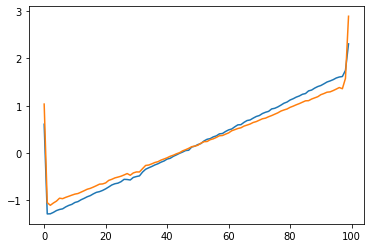

In [3]:
# read data and directly map to twix_array
epi_map = twixtools.map_twix(os.path.join(example_dir, 'epi.dat'))
pc_array = epi_map[-1]['phasecorr'].copy()

# set averaging flags
pc_array.flags['remove_os'] = True
pc_array.flags['average']['Lin']=True
pc_array.flags['average']['Par']=True

# print singleton_dims, to make sure that we select the correct data + shape
print(pc_array.dims)
print(pc_array.non_singleton_dims)

# phase difference in image space by complex multiplication (keeps magnitude for weighted average)
pc = ifftnd(pc_array[:])
pc = pc[:,:,:,:,:,[0]] * np.conj(pc[:,:,:,:,:,[1]])

# plot phase difference for all channels
plt.plot(np.angle(pc.squeeze()).T)

['Lin', 'Cha', 'Col']


(-0.5, 99.5, -0.5, 99.5)

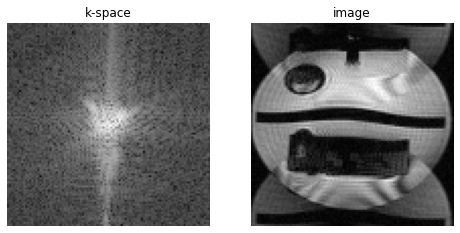

In [4]:
im_array = epi_map[-1]['image'].copy()

im_array.flags['remove_os'] = True
im_array.flags['average']['Seg'] = True
pc_array.flags['average']['Lin']=True
pc_array.flags['average']['Par']=True

print(im_array.non_singleton_dims)

data = im_array[:].squeeze()

plt.figure(figsize=[8,6])
plt.subplot(121)
plt.title('k-space')
plt.imshow(abs(data[:,0])**0.2, cmap='gray', origin='lower')
plt.axis('off')

image = ifftnd(data, [0,-1])
image = rms_comb(image)
plt.subplot(122)
plt.title('image')
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')

In [5]:
# for phase-correction, we need to keep the individual segments
im_array = epi_map[-1]['image'].copy()
im_array.flags['remove_os'] = True

pc_array = epi_map[-1]['phasecorr'].copy()
pc_array.flags['remove_os'] = True
pc_array.flags['skip_empty_lead']=True


pc = ifftnd(pc_array[:])

x = np.arange(pc_array.shape[-1]) - pc_array.shape[-1]//2

# calculate phase slope from autocorrelation (for both readout polarities separately - each in its own dim)
slope = np.angle((np.conj(pc[...,1:]) * pc[...,:-1]).sum(-1, keepdims=True).sum(-2, keepdims=True))
pc_corr = np.exp(1j * slope * x)

data = im_array[:]
image_pc = ifftnd(data, [-1])

# apply slope
image_pc *= pc_corr
image_pc = image_pc.sum(5).squeeze()
image_pc = ifftnd(image_pc, [0])

image_pc = rms_comb(image_pc)

plt.figure(figsize=[8,6])

plt.subplot(121)
plt.title('image')
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')
plt.subplot(122)
plt.title('after phase-correction')
plt.imshow(image_pc, cmap='gray', origin='lower')
plt.axis('off')

ValueError: 'ushLine' is not in list

In [ ]:
# now activate regridding:
im_array.flags['regrid'] = True
pc_array.flags['regrid'] = True



pc = ifftnd(pc_array[:])

x = np.arange(pc_array.shape[-1]) - pc_array.shape[-1]//2

# calculate phase slope from autocorrelation (for both readout polarities separately - each in its own dim)
slope = np.angle((np.conj(pc[...,1:]) * pc[...,:-1]).sum(-1, keepdims=True))
pc_corr = np.exp(1j * slope * x)

data = im_array[:]
image_pc_regrid = ifftnd(data, [-1])
# apply slope
image_pc_regrid *= pc_corr
image_pc_regrid = image_pc_regrid.sum(5).squeeze()
image_pc_regrid = ifftnd(image_pc_regrid, [0])

image_pc_regrid = rms_comb(image_pc_regrid)


plt.figure(figsize=[12,6])

plt.subplot(131)
plt.title('image')
plt.imshow(image, cmap='gray', origin='lower')
plt.axis('off')

plt.subplot(132)
plt.title('after phase-correction')
plt.imshow(image_pc, cmap='gray', origin='lower')
plt.axis('off')

plt.subplot(133)
plt.title('after phase-correction and regridding')
plt.imshow(image_pc_regrid, cmap='gray', origin='lower')
plt.axis('off')


In [ ]:
im_array.rs_traj.shape
im_array.mdb_list[0].mdh['fReadOutOffcentre']

In [ ]:
im_data.flags['squeeze_ave_dims'] = False
im_data.shape

In [ ]:
im_data.flags['squeeze_ave_dims'] = True
im_data.flags['average']['Seg'] = True
im_data.flags['average']['Set'] = True
im_data.flags['average']['Phs'] = True
im_data.shape

In [ ]:
twix = twixtools.read_twix('/data/meas/meas_MID00379_FID32464_bSSFP_TR3400_20sl.dat')
array = twixtools.map_twix(twix)

Software version: VD/VE (!?)

Scan  0
 56 % parsed in 22 s. Estimated 17 s remaining.

In [ ]:
array[-1]['image'].flags['squeeze_ave_dims'] = True
array[-1]['image'].flags['average']['Set'] = True
array[-1]['image'].flags['average']['Seg'] = True
array[-1]['image'].flags['average']['Phs'] = True
array[-1]['image'].flags['average']['Eco'] = True
array[-1]['image'].flags['average']['Sli'] = True
array[-1]['image'].flags['average']['Ave'] = True
array[-1]['image'].shape


data = array[-1]['image'][-2,:,:,1,260]
data.shape

# data = array[-1]['image'][0,0,0,0,0,0,0,-1,0,0,:,0,0,:,0,260]

(-0.5, 207.5, 19.5, -0.5)

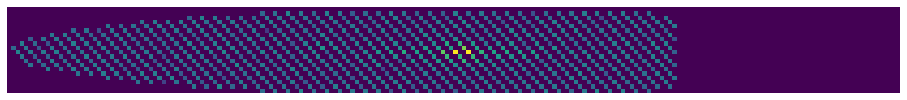

In [8]:
plt.figure(figsize=(16,8))
plt.imshow(abs(data)**0.2)
plt.axis('off')


In [9]:
%timeit array[-1]['image'][-2,:,:,1,260]

331 ms ± 30.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# (20, 208, 32, 520)

%timeit array[-1]['image'][-2,:,:,:,:]

952 ms ± 3.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
# 7.1G for 65 images
print(7.1 * 1024/65)
20*208*32*520 * 8 / 1024 /1024

111.85230769230769


528.125

In [34]:
im = array[-1]['image']

sLC = im.mdb_list[0].mdh['sLC']
counters = sLC[im.sorted_mdh_keys]\
                .astype(im.dt_counters)

mdh_dims = [dim for dim in im.dims if dim not in ['Cha', 'Col']]

print(im.key_map)
print(sLC.dtype.names)
print(counters.dtype.names)
print(im.sorted_mdh_keys)

{'Ide': 'ushIde', 'Idd': 'ushIdd', 'Idc': 'ushIdc', 'Idb': 'ushIdb', 'Ida': 'ushIda', 'Seg': 'ushSeg', 'Set': 'ushSet', 'Rep': 'ushRepetition', 'Phs': 'ushPhase', 'Eco': 'ushEcho', 'Par': 'ushPartition', 'Sli': 'ushSlice', 'Ave': 'ushAcquisition', 'Lin': 'ushLine'}
('ushLine', 'ushAcquisition', 'ushSlice', 'ushPartition', 'ushEcho', 'ushPhase', 'ushRepetition', 'ushSet', 'ushSeg', 'ushIda', 'ushIdb', 'ushIdc', 'ushIdd', 'ushIde')
('Ide', 'Idd', 'Idc', 'Idb', 'Ida', 'Seg', 'Set', 'Rep', 'Phs', 'Eco', 'Par', 'Sli', 'Ave', 'Lin')
['ushIde', 'ushIdd', 'ushIdc', 'ushIdb', 'ushIda', 'ushSeg', 'ushSet', 'ushRepetition', 'ushPhase', 'ushEcho', 'ushPartition', 'ushSlice', 'ushAcquisition', 'ushLine']


In [35]:
mdh_dims

['Rep', 'Par', 'Lin']

In [39]:
bla = [im.key_map[d] for d in mdh_dims]

In [43]:
print(im.key_map.keys())


dict_keys(['Ide', 'Idd', 'Idc', 'Idb', 'Ida', 'Seg', 'Set', 'Rep', 'Phs', 'Eco', 'Par', 'Sli', 'Ave', 'Lin'])


In [48]:
im.key_map.values()

dict_values(['ushIde', 'ushIdd', 'ushIdc', 'ushIdb', 'ushIda', 'ushSeg', 'ushSet', 'ushRepetition', 'ushPhase', 'ushEcho', 'ushPartition', 'ushSlice', 'ushAcquisition', 'ushLine'])

In [6]:
np.asarray(im_array.mdb_list[0].mdh['sLC'])

array((0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
      dtype=[('ushLine', '<u2'), ('ushAcquisition', '<u2'), ('ushSlice', '<u2'), ('ushPartition', '<u2'), ('ushEcho', '<u2'), ('ushPhase', '<u2'), ('ushRepetition', '<u2'), ('ushSet', '<u2'), ('ushSeg', '<u2'), ('ushIda', '<u2'), ('ushIdb', '<u2'), ('ushIdc', '<u2'), ('ushIdd', '<u2'), ('ushIde', '<u2')])

In [6]:
mdhLC = [("ushLine", "<u2"),
         ("ushAcquisition", "<u2"),
         ("ushSlice", "<u2"),
         ("ushPartition", "<u2"),
         ("ushEcho", "<u2"),
         ("ushPhase", "<u2"),
         ("ushRepetition", "<u2"),
         ("ushSet", "<u2"),
         ("ushSeg", "<u2"),
         ("ushIda", "<u2"),
         ("ushIdb", "<u2"),
         ("ushIdc", "<u2"),
         ("ushIdd", "<u2"),
         ("ushIde", "<u2")]

['ushLine',
 'ushAcquisition',
 'ushSlice',
 'ushPartition',
 'ushEcho',
 'ushPhase',
 'ushRepetition',
 'ushSet',
 'ushSeg',
 'ushIda',
 'ushIdb',
 'ushIdc',
 'ushIdd',
 'ushIde']